<a href="https://colab.research.google.com/github/jahanshukhy/Intro-to-Machine-Learning/blob/main/HW7_prb2bdropout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Download CIFAR-10, convert to tensor and normalize

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2470, 0.2435, 0.2616]
    ),
])

data_path = "./data-cifar10/"

trainset = datasets.CIFAR10(root=data_path, train=True, download=True, transform=transform)
valset   = datasets.CIFAR10(root=data_path, train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
valloader   = DataLoader(valset,   batch_size=128, shuffle=False)


Using device: cuda


100%|██████████| 170M/170M [00:13<00:00, 12.9MB/s]


In [2]:
# Build Residual block

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        # First convolution
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        # Second convolution
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.dropout = nn.Dropout(p=0.3) # add dropout

        # shortcut path (identity or 1x1 conv with downsampling)
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1,
                          stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.shortcut = nn.Identity()

    def forward(self, x):
        identity = self.shortcut(x)

        out = F.relu(self.bn1(self.conv1(x)))
        out = self.dropout(out) #add dropout
        out = self.bn2(self.conv2(out))

        out = F.relu(out + identity)
        return out



In [3]:
# Build ResNet-10

class ResNet10(nn.Module):
    def __init__(self):
        super().__init__()

        # Initial convolution
        self.conv_in = nn.Conv2d(3, 16, kernel_size=3, stride=1,
                                 padding=1, bias=False)
        self.bn_in = nn.BatchNorm2d(16)

        # Create layers (2 blocks per layer)
        self.layer1 = self._make_layer(16, 16, num_blocks=2, stride=1)
        self.layer2 = self._make_layer(16, 32, num_blocks=2, stride=2)
        self.layer3 = self._make_layer(32, 64, num_blocks=2, stride=2)
        self.layer4 = self._make_layer(64, 128, num_blocks=2, stride=2)

        # Global Average Pooling
        self.avg_pool = nn.AdaptiveAvgPool2d((1,1))

        # Final fully connected layer
        self.fc = nn.Linear(128, 10)

    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride))

        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels, stride=1))

        return nn.Sequential(*layers)

    def forward(self, x):

        x = F.relu(self.bn_in(self.conv_in(x)))

        x = self.layer1(x)   # 32×32
        x = self.layer2(x)   # 16×16
        x = self.layer3(x)   # 8×8
        x = self.layer4(x)   # 4×4

        x = self.avg_pool(x) # 1×1

        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


In [4]:
model = ResNet10().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Model size(trainable parameters):", count_params(model))


Model size(trainable parameters): 701466


In [5]:
def train_model(num_epochs=300):
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    start_time = time.time()

    for epoch in range(num_epochs):
        epoch_start = time.time()
        model.train()
        running_loss, correct, total = 0, 0, 0

         # Training loop
        for imgs, labels in trainloader:
            imgs, labels = imgs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(trainloader)
        train_acc  = correct / total

        # Validation loop
        model.eval()
        v_loss, v_correct, v_total = 0, 0, 0

        with torch.no_grad():
            for imgs, labels in valloader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, labels)

                v_loss += loss.item()
                _, pred = torch.max(outputs, 1)
                v_total += labels.size(0)
                v_correct += (pred == labels).sum().item()

        val_loss = v_loss / len(valloader)
        val_acc  = v_correct / v_total

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        epoch_time = time.time() - epoch_start

        print(f"Epoch {epoch+1:3d} | Time: {epoch_time:6.2f} s | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
              f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    total_time = (time.time() - start_time) / 60
    print(f"Training complete in {total_time:.2f} minutes")

    return train_losses, val_losses, train_accs, val_accs


Epoch   1 | Time:  24.36 s | Train Loss: 1.4544 | Val Loss: 1.1374 | Train Acc: 0.4643 | Val Acc: 0.5863
Epoch   2 | Time:  22.81 s | Train Loss: 1.0373 | Val Loss: 0.9118 | Train Acc: 0.6278 | Val Acc: 0.6737
Epoch   3 | Time:  22.58 s | Train Loss: 0.8523 | Val Loss: 0.8889 | Train Acc: 0.6975 | Val Acc: 0.6909
Epoch   4 | Time:  22.62 s | Train Loss: 0.7482 | Val Loss: 0.7551 | Train Acc: 0.7358 | Val Acc: 0.7356
Epoch   5 | Time:  22.66 s | Train Loss: 0.6669 | Val Loss: 0.6891 | Train Acc: 0.7644 | Val Acc: 0.7589
Epoch   6 | Time:  22.64 s | Train Loss: 0.6141 | Val Loss: 0.6214 | Train Acc: 0.7837 | Val Acc: 0.7822
Epoch   7 | Time:  22.74 s | Train Loss: 0.5639 | Val Loss: 0.6791 | Train Acc: 0.8013 | Val Acc: 0.7632
Epoch   8 | Time:  22.69 s | Train Loss: 0.5204 | Val Loss: 0.5888 | Train Acc: 0.8170 | Val Acc: 0.8012
Epoch   9 | Time:  22.64 s | Train Loss: 0.4893 | Val Loss: 0.5655 | Train Acc: 0.8280 | Val Acc: 0.8077
Epoch  10 | Time:  22.56 s | Train Loss: 0.4567 | Val L

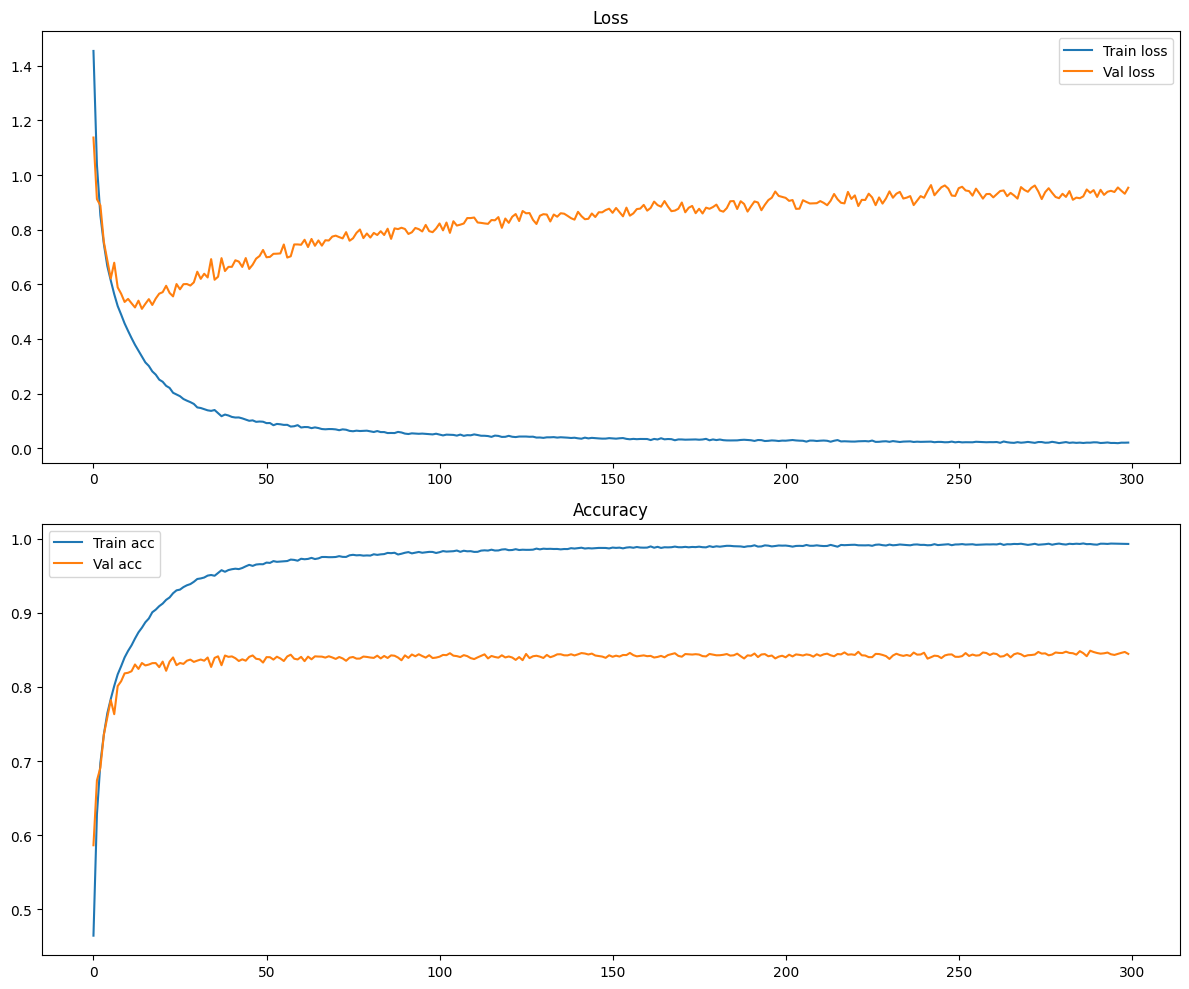

In [6]:
# Training and plot Curves

train_losses, val_losses, train_accs, val_accs = train_model(300)

plt.figure(figsize=(12,10))
plt.subplot(2,1,1)
plt.plot(train_losses, label="Train loss")
plt.plot(val_losses, label="Val loss")
plt.legend(), plt.title("Loss")

plt.subplot(2,1,2)
plt.plot(train_accs, label="Train acc")
plt.plot(val_accs, label="Val acc")
plt.legend(), plt.title("Accuracy")

plt.tight_layout()
plt.show()
